In [1]:
import numpy as np
from time import time
from matplotlib import pyplot as plt

from GIF_Export import *

In [2]:
# U: field | h: spatial discretization step
# Returns: Numerical second derivative approximation field
def d2_dx2(U, h):
    Nx, Ny = U.shape
    derv = np.zeros((Nx+2, Ny+2), dtype = np.float64)

    derv[:-2, 1:-1]  += U
    derv[1:-1, 1:-1] -= 2*U
    derv[2:, 1:-1]   += U
    derv /= h**2

    derv = derv[1:-1, 1:-1]

    derv[0, :] = derv[-1, :] = derv[:, 0] = derv[:, -1] = 0

    return derv

# U: field | h: spatial discretization step
# Returns: Numerical second derivative approximation field
def d2_dy2(U, h):
    Nx, Ny = U.shape 
    derv = np.zeros((Nx+2, Ny+2), dtype = np.float64)

    derv[1:-1, :-2]  += U
    derv[1:-1, 1:-1] -= 2*U
    derv[1:-1, 2:]   += U
    derv /= h**2

    derv = derv[1:-1, 1:-1]

    derv[0, :] = derv[-1, :] = derv[:, 0] = derv[:, -1] = 0

    return derv

# U: field | h: spatial discretization step
# Returns: Numerical mixed derivative approximation field
def d2_dxdy(U, h):
    Nx, Ny = U.shape
    derv = np.zeros((Nx+2, Ny+2), dtype = np.float64)

    derv[:-2, :-2] += U
    derv[2:, 2:]   += U
    derv[:-2, 2:]  -= U
    derv[2:, :-2]  -= U
    derv /= (4*h**2)

    derv = derv[1:-1, 1:-1]

    derv[0, :] = derv[-1, :] = derv[:, 0] = derv[:, -1] = 0

    return derv

In [3]:
# E: Young modulus  |  nu: Poisson ratio  |  rho: density
# Returns: sound wave speed in material (field/value)
def wave_speed(E, nu, rho):
    C = np.sqrt(E / (rho * (1 - nu**2)))
    return C

# matprops: list [E, nu, rho]  | dh: spatial discretization step  |  dt: time discretization step |   cfl_max: CFL constant
# Returns: whether Courant-Friedrichs-Levy condition is satisfied or not (True / False)
def CFL_check(matprops, dh, dt, cfl_max = 1.0):
    E, nu, rho = matprops
    C = wave_speed(E, nu, rho)

    cfl = np.max(C)*dt/dh
    print(f'CFL: {cfl}')
    return cfl <= cfl_max

In [4]:
# model: numpy.ndarray describing materials distribution  |  dict_: value dict
# Returns: constructed field (e.g., Young modulus field)
def fill_value(model, dict_):
    field = np.zeros_like(model)
    for i in dict_:
        field[model == i] = dict_[i]
    return field

In [5]:
# matprops: [E, nu, rho],  |  dh: spatial step  |  dt: time step  |  n_steps: time steps
# init conds: [[ux_0, uy_0], [ux_1, uy_1]]      |  bound_conds: [[ux_bc_0, uy_bc_0, fx_0, fy_0, fix_x_0, fix_y_0], ... --//--] 
# * 
# Returns: ux & uy displacements history
def Mech_FDM_2D(matprops, dh, dt, n_steps, init_conds, bound_conds):
    E, nu, rho = matprops

    C1 = E / (1 - nu**2)
    C2 = (1 - nu) / 2

    ux_hist = [ init_conds[0][0], init_conds[1][0] ]
    uy_hist = [ init_conds[0][1], init_conds[1][1] ]

    for i in range(2, n_steps):
        ux_bc, uy_bc, fx_bc, fy_bc, fix_x, fix_y = bound_conds[i]

        ux = ux_hist[-1].copy()
        uy = uy_hist[-1].copy()

        LHS_x = C1 * d2_dx2(ux, h) + C1*nu * d2_dxdy(uy, h) + 0.5*C1*C2 * (d2_dy2(ux, h) + d2_dxdy(uy, h)) + fx_bc
        LHS_y = 0.5*C1*C2 * (d2_dxdy(ux, h) + d2_dx2(uy, h)) + C1*nu * d2_dxdy(ux, h) + C1 * d2_dy2(uy, h) + fy_bc

        ux_next = LHS_x / rho * (dt**2) + 2*ux - ux_hist[-2]
        uy_next = LHS_y / rho * (dt**2) + 2*uy - uy_hist[-2]

        ux_next[fix_x == 1] = 0.0
        uy_next[fix_y == 1] = 0.0

        ux_next[ux_bc != 0] = ux_bc[ux_bc != 0]
        uy_next[uy_bc != 0] = uy_bc[uy_bc != 0]

        ux_hist.append(ux_next)
        uy_hist.append(uy_next)

    return ux_hist, uy_hist

In [6]:
# Domain setup 
Nx = 80
Ny = 80

h = 2e-3

print(f'Domain shape: {Nx} x {Ny}')
print(f'Total dimension: {Nx*Ny}')

Domain shape: 80 x 80
Total dimension: 6400


In [7]:
dt = 3.27e-7
simulation_time = 1e-4

n_steps = round(simulation_time / dt)
print(f'Time Steps: {n_steps}')

Time Steps: 306


In [8]:
# Materials distribution
model = np.zeros((Nx, Ny))

x0 = 80
y0 = Ny//2
X, Y = np.meshgrid(np.arange(Nx), np.arange(Ny), indexing = 'ij')
RAD  = np.sqrt((X - x0)**2 + (Y - y0)**2)


# model[RAD <= 9] = 1
model[Nx//2-5:Nx//2+5, Ny//2-5:Ny//2+5] = 0

In [9]:
materials = {
    0: [2e11, 0.3, 7850], # Steel
    1: [7.9e10, 0.44, 19300] # Gold
}

E_dict   = {i: materials[i][0] for i in materials}
nu_dict  = {i: materials[i][1] for i in materials}
rho_dict = {i: materials[i][2] for i in materials}

E   = fill_value(model, E_dict)
nu  = fill_value(model, nu_dict)
rho = fill_value(model, rho_dict)

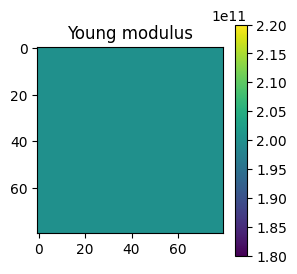

In [10]:
plt.figure(figsize = (3,3))
plt.imshow(E)
plt.colorbar()
plt.title('Young modulus')
plt.show()

In [11]:
# Formulating boundary conditions
boundary_conds = []
shape = model.shape

imp_start = 0
imp_end   = 4
imp_max   = 2e-5

delta_u = 1e-1

for i in range(n_steps):
    ux_i = np.zeros(shape)
    uy_i = np.zeros(shape)
    fx_i = np.zeros(shape)
    fy_i = np.zeros(shape)
    fix_x = np.zeros(shape)
    fix_y = np.zeros(shape)

    if (i <= imp_end):
        ux_i[3, Ny//2-3:Ny//2+3] = imp_max/imp_end*i

    # fix_x[-1, :] = 1
    # fix_y[-1, :] = 1

        #uy_i[-3:, :] = n_steps//2*delta_u

        #fix_x[-4, :] = 1
        #fix_y[-4, :] = 1

    boundary_conds.append([ux_i, uy_i, fx_i, fy_i, fix_x, fix_y])

# Formulating initial conditions
init_conds = [
    [boundary_conds[0][0], boundary_conds[0][1]],
    [boundary_conds[1][0], boundary_conds[1][1]]
]

In [12]:
# Checking CFL
print(f'CFL satisfied: {CFL_check([E, nu, rho], h, dt)}')

CFL: 0.8651217491153074
CFL satisfied: True


In [13]:
calc_start = time()
ux_hist, uy_hist = Mech_FDM_2D([E, nu, rho], h, dt, n_steps, init_conds, boundary_conds)
calc_end = time()

print(f'Calc taken: {calc_end - calc_start :.3f} sec')

Calc taken: 0.132 sec


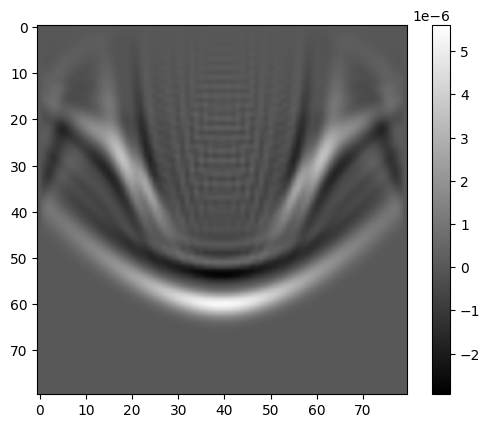

In [15]:
plt.imshow(ux_hist[70], cmap = 'gist_grey', interpolation = 'gaussian')
plt.colorbar()
plt.show()

In [16]:
data = [np.abs(ux) for ux in ux_hist[:]]
vmin = 0.0
vmax = np.max(np.array(data))
cmap = 'PuBuGn'
scale = 5

save_GIF(data, scale, cmap, vmin, vmax, True, duration_ms = 35)